# About Data
Data terdiri dari informasi bangunan di wilayah yang terkena gempa yang digunakan untuk babak penyisihan JOINTS UGM 2023

Dataset terdiri dari beberapa kolom diantaranya :
1. floors_before_eq (total) : jumlah total lantai pada bangunan sebelum gempa terjadi
2. old_building : usia bangunan (tahun)
3. plinth_area (ft^2) : luas bangunan (ft^2)
4. height_before_eq (ft) : tinggi bangunan sebelum terjadi gempa (kaki)
5. land_surface_condition : kondisi permukaan tanah disaat bangunan akan dibangun
6. type_of_foundation : jenis fondasi yang dipakai untuk bangunan tsb
7. type_of_roof : jenis atap yang dipakai untuk bangunan tsb
8. type_of_ground_floor : jenis lantai yang dipakai untuk ground-floor
9. type_of_other_floor : jenis lantai yang dipakai untuk selain ground-floor
10. position : Posisi bangunan tersebut apakah bersisian secara langsung dengan bangunan lain
11. building_plan_configuration : konfigurasi bangunan yang berkaitan dengan bentuk, ukuran, dan penempatan struktur utama bangunan
12. technical_solution_proposed : Solusi yang ditawarkan untuk bangunan yang terdampak gempa
13. legal_ownership_status : Status kepemilikan bangunan
14. has_secondary_use : Keterangan apakah bangunan memiliki kegunaan sekunder
15. type_of_reinforcement_concrete : Tipe beton bertulang/reinforcement concrete
16. residential_type : Tipe penggunaaan sebagai hunian
17. no_family_residing : Jumlah keluarga yang tinggal dalam bangunan tersebut
18. public_place_type : Tipe penggunaan sebagai tempat umum
19. industrial_use_type : Tipe industri
20. govermental_use_type : Tipe penggunaan sebagai bangunan pemerintahan
21. flexible_superstructure : Keterangan penggunaan superstructure yang fleksibel
22. wall_binding : Material yang digunakan sebagai perekat bahan pembentuk dinding
23. wall_material : Material dasar sebagai pembangun dinding
24. damage_grade (variabel target) : Tingkat kerusakan yang disebabkan oleh gempa (1-5)

Hal ini ditambah dengan beberapa penjelasan fitur :

type_of_reinforcement_concrete
- 0 : Unknown/not stated
- 1 : Clay
- 2 : Mortar + Cement
- 3 : Mortar + Cement, Clay
- 5 : Mud + Mortar, Clay
- 7 : Mud + Mortar, Clay, Cement + Mortar

wall_material
- 0 : Unknown/not stated
- 1 : Red Bricks
- 2 : Stone Bricks
- 3 : Red Bricks, Stone Bricks

type_of_reinforcement_concrete
- 0 : No reinforcement concrete
- 1 : Has non-engineered reinforcement concrete
- 2 : Has engineered reinforcement concrete
- 3 : Has both

# Tujuan
Menganalisis karakteristik bangunan yang memiliki tingkat kerusakan yang rendah

# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
from scipy.stats import chi2_contingency
from sklearn.feature_selection import VarianceThreshold

# models
import optuna
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier

# metric used for the competition
from sklearn.metrics import f1_score

# Analisis Sekilas Data

In [164]:
original = pd.read_csv('..\\Datasets\\train.csv.zip', compression='zip',index_col = "Unnamed: 0")

d:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1,3,5,6,7,8,9,10,11,12,13,16,17,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [232]:
path = "building_materials.csv"
df = pd.read_csv(path,index_col = "Unnamed: 0")

test_path = "..\\Datasets\\test.csv.zip"
test = pd.read_csv(test_path,compression="zip", index_col='id')
test = test.sort_index()
test = test.reset_index(drop=True)

df.head()

,type_of_foundation,type_of_roof,type_of_ground_floor,type_of_other_floor,type_of_reinforcement_concrete,wall_binding,wall_material
0,Bamboo/Timber,Bamboo/Timber Light roof,Clay,Timber/Bamboo-Mud,0.0,0.0,0.0
1,mortar-Stone/Brick,Wood Light roof/Bamboo Heavy roof,Clay,Timber/Bamboo-Mud,0.0,5.0,2.0
2,mortar-Stone/Brick,Bamboo/Timber Light roof,Clay,Wood-Mud/Bamboo Mud,0.0,5.0,2.0
3,mortar-Stone/Brick,Bamboo/Timber Light roof,Clay,Wood-Mud/Bamboo Mud,0.0,5.0,2.0
4,mortar-Stone/Brick,Wood Light roof/Bamboo Light roof,Clay,Timber/Bamboo-Mud,0.0,5.0,2.0


### ROOF

In [166]:
original['type_of_roof'].value_counts()

Bamboo/Timber Light roof                79640
Wood Light Roof or Bamboo Heavy Roof    70095
Wood Light Roof or Bamboo Light Roof    59880
Bamboo/TImber-Light Roof                40081
Bamboo or Timber Light roof             19974
reinforced cement concrete/rb/rbc       10315
Bamboo/Timber Heavy roof                 8406
Bamboo/TImber-Heavy Roof                 4225
rcc/rb/rbc                               3553
Reinforced Brick Slab/rcc/rbc            2468
Bamboo or Timber Heavy roof              1722
Reinforced brick concrete/rcc/rbc        1248
Name: type_of_roof, dtype: int64

In [233]:
df['type_of_roof'] = df['type_of_roof'].replace({
    'Bamboo or Timber-Light roof' : 'Bamboo/Timber Light roof',
    'Bamboo or Timber Light roof' : 'Bamboo/Timber Light roof',
    'Bamboo or Timber Heavy roof' : 'Bamboo/Timber Heavy roof',
    'Wood Light Roof or Bamboo Light Roof' : 'Wood Light roof/Bamboo Light roof',
    'Wood Light Roof or Bamboo Heavy Roof' : 'Wood Light roof/Bamboo Heavy roof',
    'Bamboo/TImber-Light Roof' : 'Bamboo/Timber Light roof',
    'reinforced cement concrete/rb/rbc' : 'rcc/rb/rbc',
    'Reinforced Brick Slab/rcc/rbc' : 'rbs/rcc/rbc',
    'Bamboo/TImber-Heavy Roof' : 'Bamboo/Timber Heavy roof',
    'Bamboo or Timber Heavy Roof' : 'Bamboo/Timber Heavy roof',
    'Reinforced brick concrete/rcc/rbc' : 'rb/rbc'
})

In [234]:
def roofAttr(df) :
    roofWeight = []
    for index, row in df.iterrows() :
        if row['type_of_roof'] == 'Wood Light roof/Bamboo Heavy roof' :
            roofWeight.append('both')
        elif 'Heavy' in row['type_of_roof'] :
            roofWeight.append('heavy')
        elif 'Light' in row['type_of_roof'] :
            roofWeight.append('light')
        else :
            roofWeight.append('neither')

    return np.array(roofWeight)

In [235]:
df['roof_weight'] = roofAttr(df=df)

In [236]:
df['roof_weight'].value_counts()

light      620303
both        70095
neither     18064
heavy       14353
Name: roof_weight, dtype: int64

In [237]:
df_roof = df.copy()

In [238]:
def processRoof(x) :
    if ' Light roof' in x :
        return x.replace(' Light roof', '')
    elif ' Heavy roof' in x :
        return x.replace(' Heavy roof', '')
    else :
        return x

df_roof['type_of_roof'] = df_roof['type_of_roof'].apply(lambda x: processRoof(x))
df_roof['type_of_roof'] = df_roof['type_of_roof'].apply(lambda x: processRoof(x))

In [239]:
df_roof['type_of_roof'].unique()

array(['Bamboo/Timber', 'Wood/Bamboo', 'rbs/rcc/rbc', 'rcc/rb/rbc',
       'rb/rbc'], dtype=object)

### OTHER FLOOR

In [245]:
df['type_of_other_floor'].unique()

array(['Timber/Bamboo-Mud', 'Wood-Mud/Bamboo Mud',
       'Timber Mud/Bamboo-Mud', 'Not applicable', 'Wood/Bamboo-Mud',
       'rcc/rb/rbc', 'Wood-Plank', 'Timber-Plank', 'Lumber-plank',
       'rcc/rbc'], dtype=object)

In [244]:
df_roof['type_of_other_floor'].unique()

array(['Timber/Bamboo-Mud', 'Wood-Mud/Bamboo Mud',
       'Timber Mud/Bamboo-Mud', 'Not applicable', 'Wood/Bamboo-Mud',
       'rcc/rb/rbc', 'Wood-Plank', 'Timber-Plank', 'Lumber-plank',
       'rcc/rbc'], dtype=object)

In [246]:
def otherFloorAttr(df) :
    bahan1 = []
    bahan2 = []
    for index, row in df.iterrows() :
        if row['type_of_other_floor'] == 'Timber/Bamboo-Mud' or row['type_of_other_floor'] == 'Timber Mud/Bamboo-Mud' :
            bahan1.append('Timber mud')
            bahan2.append('Bamboo mud')
        elif row['type_of_other_floor'] == 'Wood-Mud/Bamboo Mud' or row['type_of_other_floor'] == 'Wood/Bamboo-Mud' :
            bahan1.append('Wood mud')
            bahan2.append('Bamboo mud')
        elif row['type_of_other_floor'] == 'Wood-Plank' :
            bahan1.append('Wood')
            bahan2.append('None')
        elif row['type_of_other_floor'] == 'Timber-Plank' :
            bahan1.append('Timber')
            bahan2.append('None')
        elif row['type_of_other_floor'] == 'Lumber-plank' :
            bahan1.append('Lumber')
            bahan2.append('None')
        elif row['type_of_other_floor'] == 'rcc/rb/rbc' :
            bahan1.append('rcc/rbc')
            bahan2.append('rb')
        elif row['type_of_other_floor'] == 'rcc/rbc' :
            bahan1.append('rcc/rbc')
            bahan2.append('None')
        else :
            bahan1.append('None')
            bahan2.append('None')

    return np.array(bahan1), np.array(bahan2)

In [250]:
df_other_floor = df_roof.copy()
df_other_floor['other_floor_m1'], df_other_floor['other_floor_m2'] = otherFloorAttr(df)

In [255]:
df_other_floor = df_other_floor.drop('type_of_other_floor', axis=1)

In [258]:
df_other_floor.to_csv('materials_pisah.csv')

### Function

In [144]:
import random

def processBuildingMaterials(row):
    # type_of_foundation
    aman_type_of_foundation = ['Bamboo/Timber','Reinforced Concrete','Cement-Stone/Brick','Other']
    bahaya_type_of_foundation = ['Clay Sand Mixed mortar-Stone/Brick','Clay mortar-Stone/Brick','Mud mortar-Stone/Brick']

    # type_of_ground_floor
    aman_type_of_ground_floor = ['Timber','Reinforced Concrete','Timber','Other','Wood','Lumber']
    bahaya_type_of_ground_floor = ['soil, water, loan Mixed','Mud','Clay']

    # type_of_other_floor
    aman_type_of_other_floor = ['rcc/rbc','Not applicable']
    bahaya_type_of_other_floor = ['Timber/Bamboo-Mud', 'Timber Mud/Bamboo-Mud', 'Wood/Bamboo-Mud','Wood-Plank','Timber-Plank','Lumber-plank','Wood-Mud/Bamboo Mud']

    # type_of_roof
    aman_type_of_roof = ['rbs/rcc/rbc','rcc/rb/rbc','rb/rbc']
    bahaya_type_of_roof = ['Bamboo/Timber Light roof','Wood Light roof/Bamboo Heavy roof','Wood Light roof/Bamboo Light roof','Bamboo/Timber Heavy roof']

    # reinforcement concrete
    aman_type_of_concrete = [1,2,3]
    bahaya_type_of_concrete = [0]

    # wall_material
    aman_wall_material = [0,1,3]
    bahaya_wall_material = [2]

    # wall_binding
    aman_wall_binding = [0,2,3,7]
    bahaya_wall_binding = [1,5]

    fillValuesAman = {'type_of_other_floor' : random.choice(aman_type_of_other_floor),
                      'type_of_foundation' : random.choice(aman_type_of_foundation),
                      'type_of_ground_floor' : random.choice(aman_type_of_ground_floor),
                      'type_of_roof' : random.choice(aman_type_of_roof),
                      'wall_material' : random.choice(aman_wall_material),
                      'wall_binding' : random.choice(aman_wall_binding),
                      'type_of_reinforcement_concrete' : random.choice(aman_type_of_concrete)}
    
    fillValuesBahaya = {'type_of_other_floor' : random.choice(bahaya_type_of_other_floor),
                        'type_of_foundation' : random.choice(bahaya_type_of_foundation),
                        'type_of_ground_floor' : random.choice(bahaya_type_of_ground_floor),
                        'type_of_roof' : random.choice(bahaya_type_of_roof),
                        'wall_material' : random.choice(bahaya_wall_material),
                        'wall_binding' : random.choice(bahaya_wall_binding),
                        'type_of_reinforcement_concrete' : random.choice(bahaya_type_of_concrete)}

    if row['damage_grade'] == 5.0 or row['damage_grade'] == 4.0:
        row.fillna(value=fillValuesAman, inplace=True)
    elif row['damage_grade'] == 1.0 or row['damage_grade'] == 2.0:
        row.fillna(value=fillValuesBahaya, inplace=True)
    elif row['damage_grade'] == 3.0:
        row.fillna(value=random.choice([fillValuesAman, fillValuesBahaya]), inplace=True)

    return row

# Handling Missing Value

Kita dapat menvisualisasikan missing value dengan library missingno sehingga lebih mudah dilihat

<AxesSubplot:>

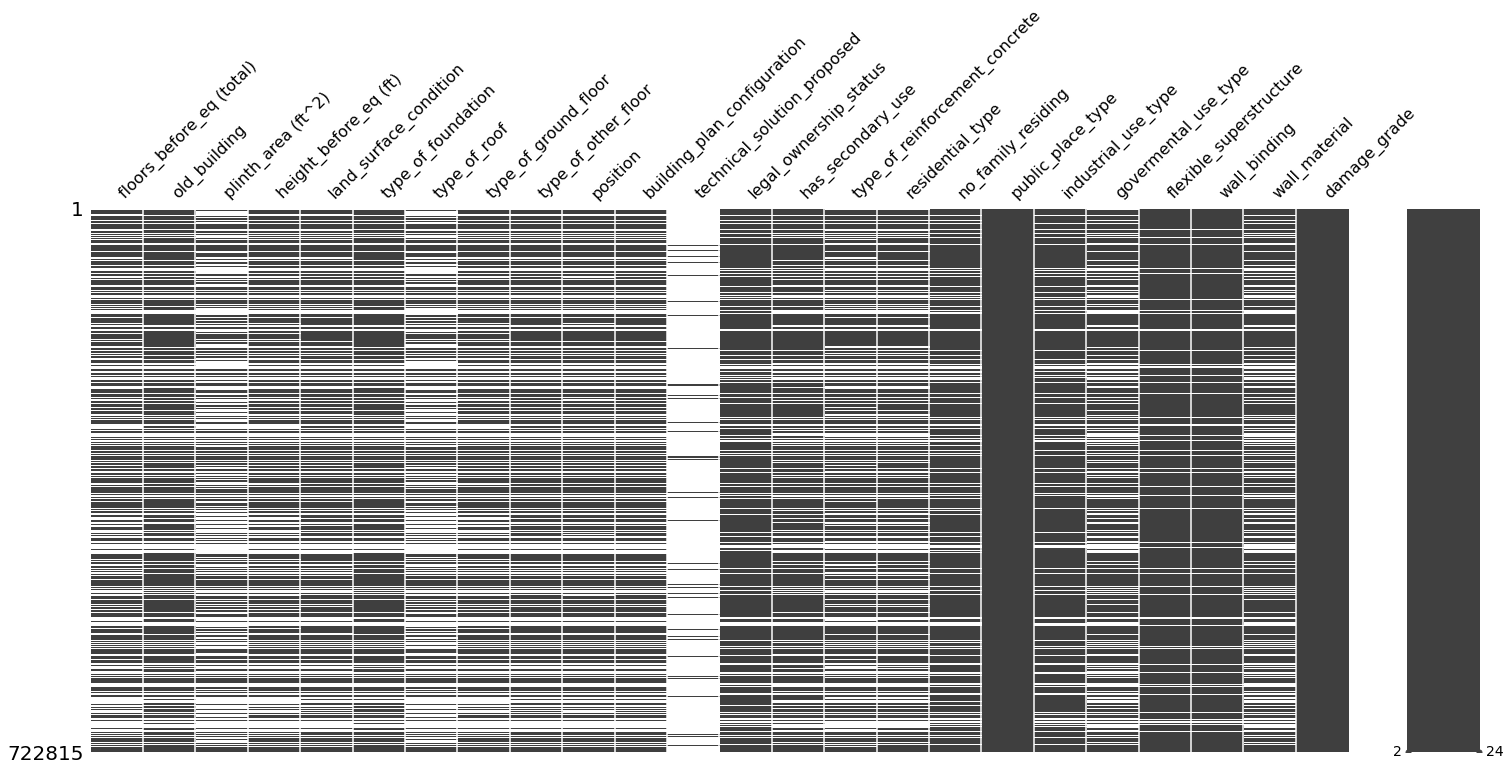

In [91]:
import missingno as msno
msno.matrix(df)

Terlihat bahwa penyebab informasi hilang terbanyak terdapat pada fitur technical_solution_proposed

Untuk melihat korelasi antara nilai yang hilang, kita dapat menggunakan heatmap dari missingno

<AxesSubplot:>

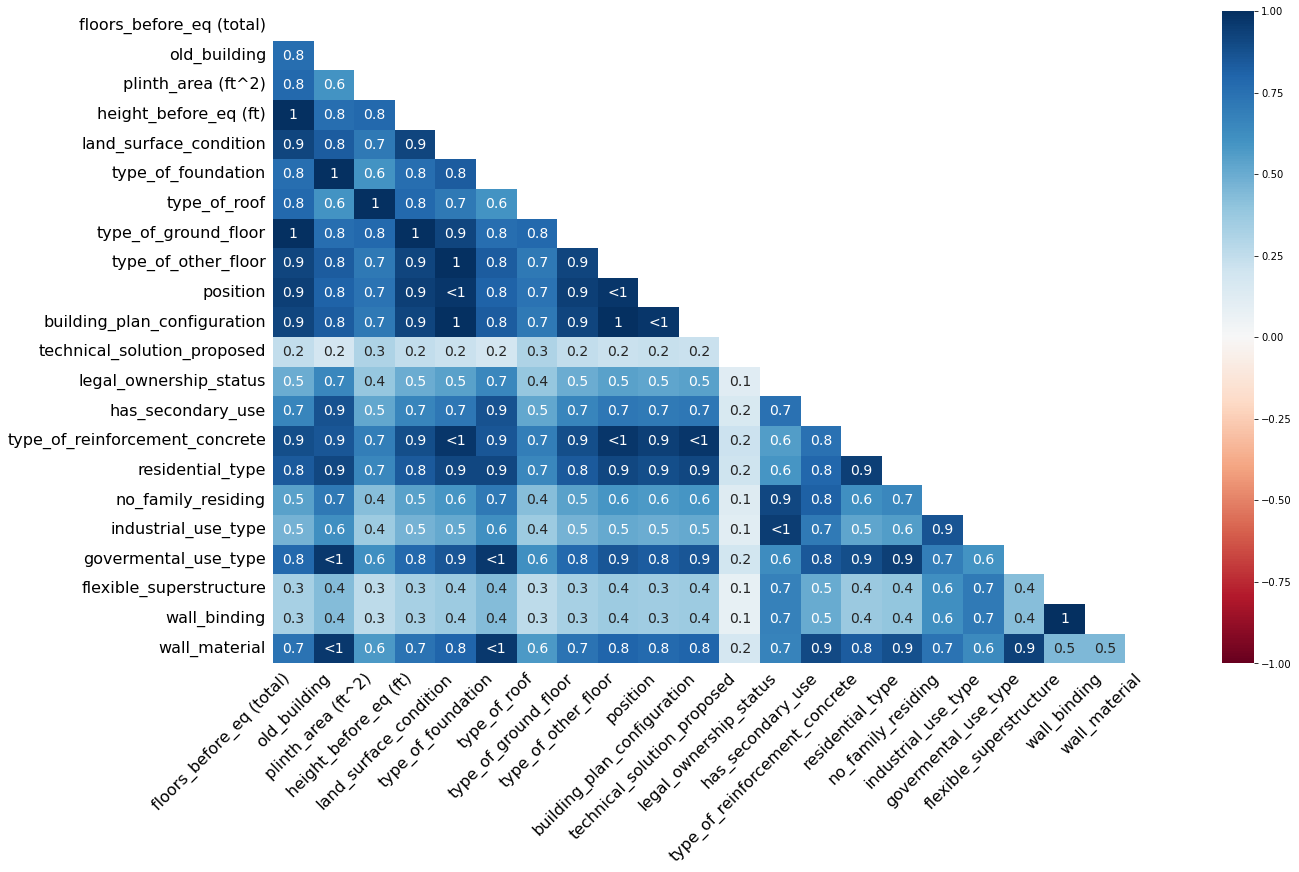

In [92]:
msno.heatmap(df)

Kita dapat melihat bahwa technical_solution_proposed memiliki ketergantungan nilai hilang yang sangat rendah dengan fitur lain, namun sesuai dengan deskripsi fitur, fitur ini adalah rekomendasi solusi terhadap bangunan yang rusak, yang seharusnya juga memiliki ikatan dengan damage_grade. 

Mari kita lihat lebih lanjut apakah isi technical_solution_proposed sesuai dengan damage grade

In [93]:
solution = df['technical_solution_proposed'].unique()[1:]
solution = ['No need', 'Minor repair', 'Major repair', 'Reconstruction']
list_sol = []
for sol in solution :
    list_sol.append([sol])

count = 0
for sol in solution :
    for damage in range(1,6,1) :
        damage_count = len(df[(df['technical_solution_proposed'] == sol) & (df['damage_grade'] == damage)][['technical_solution_proposed', 'damage_grade']])
        list_sol[count].append(damage_count)
    count += 1

df_sol = pd.DataFrame(list_sol, columns=['Solution','Grade 1','Grade 2','Grade 3', 'Grade 4', 'Grade 5'])

In [94]:
df_sol

,Solution,Grade 1,Grade 2,Grade 3,Grade 4,Grade 5
0,No need,3106,30,3,0,0
1,Minor repair,1701,4534,598,16,3
2,Major repair,25,600,6293,1042,3
3,Reconstruction,9,149,1554,10176,16959


Terlihat beberapa solution tidak sesuai dengan damage, mari kita visualisasikan sehingga dapat terlihat lebih jelas

Text(0.5, 0, '')

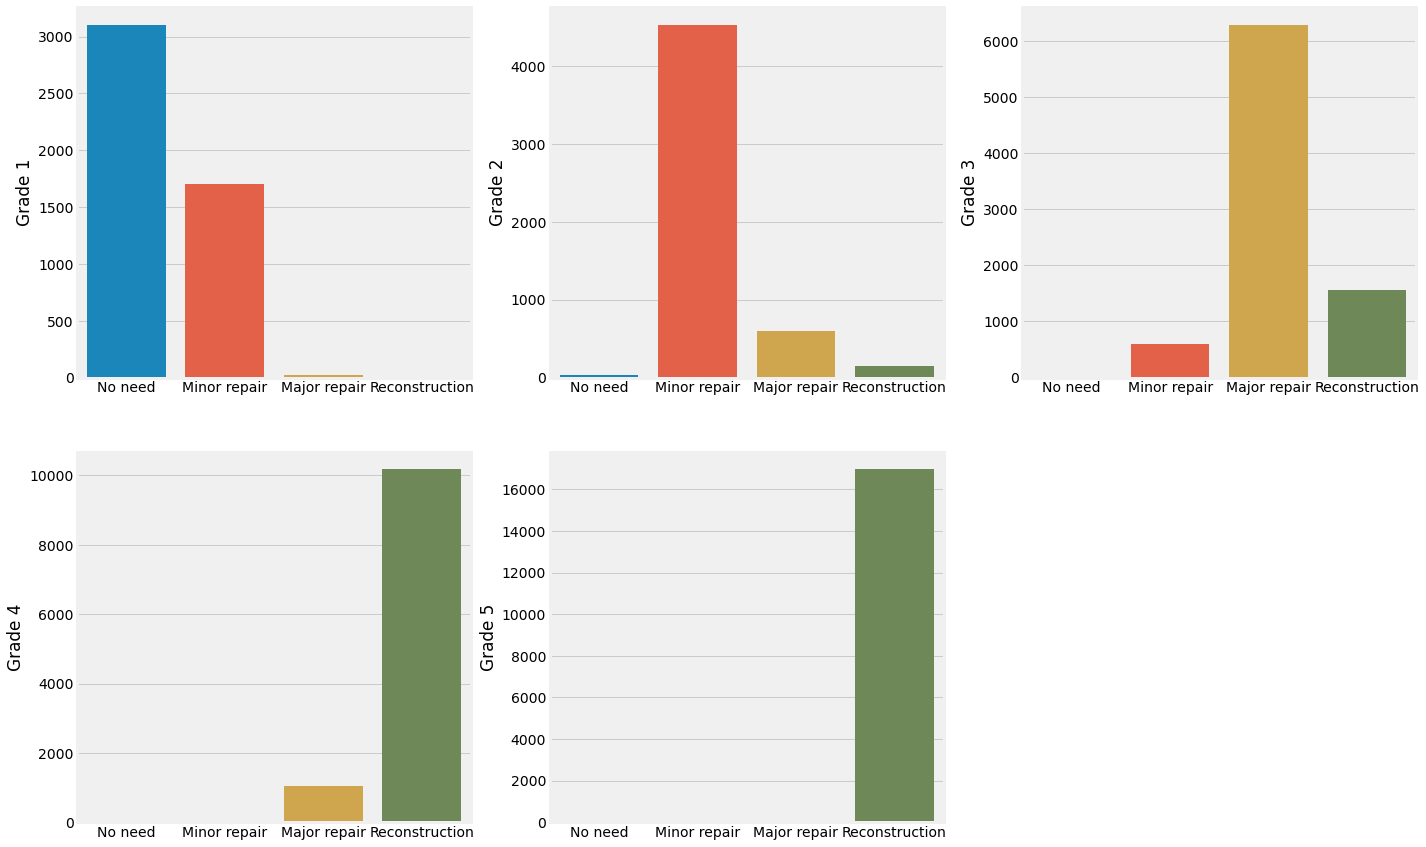

In [95]:
plt.figure(figsize=(24,15))
plt.style.use('fivethirtyeight')

plt.subplot(2,3,1)
sns.barplot(x=df_sol['Solution'],y=df_sol['Grade 1'])
plt.xlabel('')

plt.subplot(2,3,2)
sns.barplot(x=df_sol['Solution'],y=df_sol['Grade 2'])
plt.xlabel('')

plt.subplot(2,3,3)
sns.barplot(x=df_sol['Solution'],y=df_sol['Grade 3'])
plt.xlabel('')

plt.subplot(2,3,4)
sns.barplot(x=df_sol['Solution'],y=df_sol['Grade 4'])
plt.xlabel('')

plt.subplot(2,3,5)
sns.barplot(x=df_sol['Solution'],y=df_sol['Grade 5'])
plt.xlabel('')

Dari visualisasi ini, kita dapat menyimpulkan bahwa sebagian besar dari solusi teknis yang diberikan sesuai dengan tingkat kerusakan bangunan, sehingga kita dapat menambah beberapa pertimbangan dalam EDA dan Modelling :

1. Dikarenakan technical_solution_proposed berpengaruh terhadap variabel target meskipun data akan hanya tersisa 6%, maka modelling akan diujicoba tanpa dan dengan fitur technical_solution_proposed
2. EDA akan dilakukan dengan melakukan drop kolom technical_solution_proposed kemudian melakukan dropna sehingga data yang hilang tidak begitu signifikan. Meskipun fitur tersebut berhubungan dengan grade damage, namun tidak relevan dengan tujuan EDA yaitu menganalisis karakterisitk bangunan yang memiliki tingkat kerusakan kecil

Selanjutnya, kita akan memerika distribusi class apabila dilakukan drop missing value dan tidak

Text(0.5, 1.0, 'Original Data')

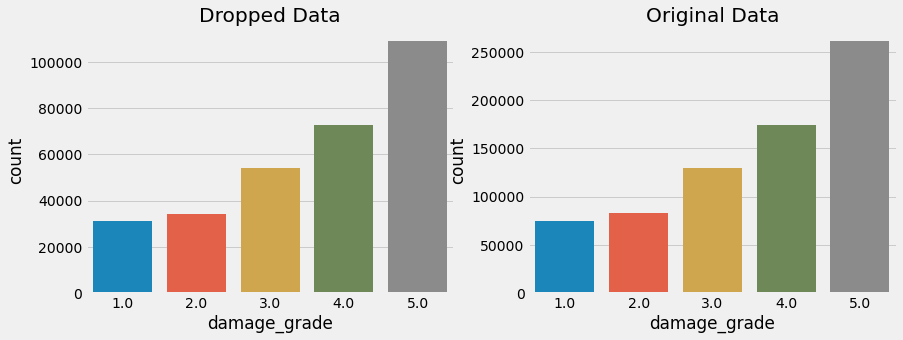

In [96]:
plt.figure(figsize=(20,10))
plt.style.use('fivethirtyeight')
df_dropped_na = df.drop('technical_solution_proposed', axis=1)
df_dropped_na = df_dropped_na.dropna()

plt.subplot(2,3,1)
sns.countplot(x=df_dropped_na['damage_grade'])
plt.title('Dropped Data')

plt.subplot(2,3,2)
sns.countplot(x=df['damage_grade'])
plt.title('Original Data')

Tidak ada perubahan yang signifikan dari kedua tipe data, oleh karena itu, data yang dilakukan drop akan diprioritaskan

In [97]:
df_dropped_na = df.copy()

df_dropped_na['public_place_type'] = df_dropped_na['public_place_type'].apply(lambda x : 'Public' if x != 'Non-public' else x)
df_dropped_na['technical_solution_proposed'] = df_dropped_na['technical_solution_proposed'].fillna(df_dropped_na.groupby(['public_place_type', 'damage_grade'])['technical_solution_proposed'].transform(lambda x: x.mode().values[0] if not x.mode().empty else None))

# Impute missing values with mode for categorical columns
categorical_cols = df_dropped_na.select_dtypes(include='object').columns  # Get the column names of categorical columns
df_dropped_na[categorical_cols] = df_dropped_na[categorical_cols].fillna(df_dropped_na.groupby(['public_place_type', 'damage_grade'])[categorical_cols].transform(lambda x: x.mode().values[0] if not x.mode().empty else None))

# Impute missing values with median for numerical columns
numerical_cols = df_dropped_na.select_dtypes(include='number').columns  # Get the column names of numerical columns

# Define a custom function to fill missing values with median, handling empty median case
def fillna_with_median(x):
    median = x.median()
    if pd.isna(median):
        return None  # or any other appropriate value
    else:
        return median

# Fill missing values with median based on 'public_place_type' and 'damage_grade'
df_dropped_na[numerical_cols] = df_dropped_na[numerical_cols].fillna(df_dropped_na.groupby(['public_place_type', 'damage_grade'])[numerical_cols].transform(fillna_with_median))

In [98]:
test['public_place_type'] = test['public_place_type'].apply(lambda x : 'Public' if x != 'Non-public' else x)

Selanjutnya adalah melakukan pembersihan data untuk dilakukan analisis lebih lanjut, pembersihan data pertama tama akan dilakukan pada kolom kategorikal

In [99]:
cat_col = df_dropped_na.select_dtypes(include=('object')).columns.tolist()
cat_col_test = test.select_dtypes(include=('object')).columns.tolist()

df_dropped_na[cat_col].head()

,floors_before_eq (total),plinth_area (ft^2),land_surface_condition,type_of_foundation,type_of_roof,type_of_ground_floor,type_of_other_floor,position,building_plan_configuration,technical_solution_proposed,legal_ownership_status,residential_type,no_family_residing,public_place_type,industrial_use_type,govermental_use_type,flexible_superstructure
0,floor two,256 ft^2,Flat,Bamboo or Timber,Bamboo/Timber Light roof,Clay,TImber/Bamboo-Mud,Not attached,Rectangular,No need,Private Use,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable
1,Floor 3,985 ft^2,Flat,Clay Sand Mixed mortar-Stone/Brick,Wood Light Roof or Bamboo Heavy Roof,Clay,TImber/Bamboo-Mud,Not attached,Square,Reconstruction,Private,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable
2,Two Floor,300 ft^2,Flat,Mud mortar-Stone/Brick,Bamboo/Timber Light roof,Clay,Wood-Mud or Bamboo Mud,Not attached,Rectangular,Reconstruction,Private Use,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable
3,Two Floor,300 ft^2,Flat,Mud mortar-Stone/Brick,Bamboo/Timber Light roof,Clay,Wood-Mud or Bamboo Mud,Not attached,Rectangular,Reconstruction,Private Use,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable
4,two,185 ft^2,Flat,Clay Sand Mixed mortar-Stone/Brick,Wood Light Roof or Bamboo Light Roof,Clay,TImber/Bamboo-Mud,Not attached,Rectangular,Reconstruction,Private,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable


In [100]:
for col in cat_col :
    print(col,':',df_dropped_na[col].nunique())

floors_before_eq (total) : 47
plinth_area (ft^2) : 930
land_surface_condition : 3
type_of_foundation : 12
type_of_roof : 12
type_of_ground_floor : 15
type_of_other_floor : 11
position : 4
building_plan_configuration : 10
technical_solution_proposed : 4
legal_ownership_status : 13
residential_type : 6
no_family_residing : 11
public_place_type : 2
industrial_use_type : 9
govermental_use_type : 3
flexible_superstructure : 2


Untuk memastikan fitur teks bersih plinth area dikesampingkan terlebih dahulu karena memiliki 855 nilai unik

Mari kita melihat lebih lanjut nilai dari setiap fitur

In [101]:
for col in [col for col in cat_col if 'plinth_area (ft^2)' not in cat_col]:
    print(col,':',df_dropped_na[col].unique().tolist(),'\n')

Beberapa fitur memiliki nilai problematik dengan delimiter dan case yang berbeda beda :
1. floors_before_eq (total)
2. type_of_foundation
3. type_of_roof
4. type_of_ground_floor
5. type_of_other_floor
6. legal_ownership_status

Pertama yang akan dibersihkan adalah fitur floors_before_eq, nilai teks akan diubah menjadi angka

In [102]:
def transform_floors_before_eq(value):
    if isinstance(value, str):
        value = value.lower()
        if any(x in value for x in ['one','first','1']) :
            return 1
        elif any(x in value for x in ['two','second','2']) :
            return 2
        elif any(x in value for x in ['three','third','3','3.00']) :
            return 3
        elif any (x in value for x in ['four','fourth','4']) :
            return 4
        elif any (x in value for x in ['five','fifth','5']) :
            return 5
        else :
            return value
    else :
        return value


df_dropped_na['floors_before_eq (total)'] = df_dropped_na['floors_before_eq (total)'].apply(lambda x : transform_floors_before_eq(x))

test['floors_before_eq (total)'] = test['floors_before_eq (total)'].apply(lambda x : transform_floors_before_eq(x))

df_dropped_na['floors_before_eq (total)'].head()

0    2
1    3
2    2
3    2
4    2
Name: floors_before_eq (total), dtype: object

Kemudian, kita melakukan pembersihan pada type_x

In [103]:
df_dropped_na['type_of_foundation'].unique()

array(['Bamboo or Timber', 'Clay Sand Mixed mortar-Stone/Brick',
       'Mud mortar-Stone/Brick', 'Clay mortar-Stone/Brick',
       'Reinforced Concrete', 'Cement-Stone or Cement-Brick',
       'Bamboo/TImber', 'Bamboo/Timber', 'RC', 'Others',
       'Cement-Stone/Brick', 'Other'], dtype=object)

In [104]:
df_dropped_na['type_of_foundation'] = df_dropped_na['type_of_foundation'].replace({
    'Cement-Stone or Cement-Brick' : 'Cement-Stone/Brick',
    'Bamboo or Timber' : 'Bamboo/Timber',
    'RC' : 'Reinforced Concrete',
    'Bamboo/TImber' : 'Bamboo/Timber',
    'Others' : 'Other'
    })

test['type_of_foundation'] = test['type_of_foundation'].replace({
    'Cement-Stone or Cement-Brick' : 'Cement-Stone/Brick',
    'Bamboo or Timber' : 'Bamboo/Timber',
    'RC' : 'Reinforced Concrete',
    'Bamboo/TImber' : 'Bamboo/Timber',
    'Others' : 'Other'
    })

df_dropped_na['type_of_foundation'].unique()

array(['Bamboo/Timber', 'Clay Sand Mixed mortar-Stone/Brick',
       'Mud mortar-Stone/Brick', 'Clay mortar-Stone/Brick',
       'Reinforced Concrete', 'Cement-Stone/Brick', 'Other'], dtype=object)

In [105]:
df_dropped_na['type_of_roof'].unique()

array(['Bamboo/Timber Light roof', 'Wood Light Roof or Bamboo Heavy Roof',
       'Wood Light Roof or Bamboo Light Roof',
       'Bamboo or Timber Light roof', 'Bamboo/TImber-Light Roof',
       'Reinforced Brick Slab/rcc/rbc', 'Bamboo/Timber Heavy roof',
       'reinforced cement concrete/rb/rbc', 'Bamboo or Timber Heavy roof',
       'Bamboo/TImber-Heavy Roof', 'rcc/rb/rbc',
       'Reinforced brick concrete/rcc/rbc'], dtype=object)

In [106]:
df_dropped_na['type_of_roof'] = df_dropped_na['type_of_roof'].replace({
    'Bamboo or Timber-Light roof' : 'Bamboo/Timber Light roof',
    'Bamboo or Timber Light roof' : 'Bamboo/Timber Light roof',
    'Bamboo or Timber Heavy roof' : 'Bamboo/Timber Heavy roof',
    'Wood Light Roof or Bamboo Light Roof' : 'Wood Light roof/Bamboo Light roof',
    'Wood Light Roof or Bamboo Heavy Roof' : 'Wood Light roof/Bamboo Heavy roof',
    'Bamboo/TImber-Light Roof' : 'Bamboo/Timber Light roof',
    'reinforced cement concrete/rb/rbc' : 'rcc/rb/rbc',
    'Reinforced Brick Slab/rcc/rbc' : 'rbs/rcc/rbc',
    'Bamboo/TImber-Heavy Roof' : 'Bamboo/Timber Heavy roof',
    'Bamboo or Timber Heavy Roof' : 'Bamboo/Timber Heavy roof',
    'Reinforced brick concrete/rcc/rbc' : 'rb/rbc'
})

test['type_of_roof'] = test['type_of_roof'].replace({
    'Bamboo or Timber-Light roof' : 'Bamboo/Timber Light roof',
    'Bamboo or Timber Light roof' : 'Bamboo/Timber Light roof',
    'Bamboo or Timber Heavy roof' : 'Bamboo/Timber Heavy roof',
    'Wood Light Roof or Bamboo Light Roof' : 'Wood Light roof/Bamboo Light roof',
    'Wood Light Roof or Bamboo Heavy Roof' : 'Wood Light roof/Bamboo Heavy roof',
    'Bamboo/TImber-Light Roof' : 'Bamboo/Timber Light roof',
    'reinforced cement concrete/rb/rbc' : 'rcc/rb/rbc',
    'Reinforced Brick Slab/rcc/rbc' : 'rbs/rcc/rbc',
    'Bamboo/TImber-Heavy Roof' : 'Bamboo/Timber Heavy roof',
    'Bamboo or Timber Heavy Roof' : 'Bamboo/Timber Heavy roof',
    'Reinforced brick concrete/rcc/rbc' : 'rb/rbc'
})

df_dropped_na['type_of_roof'].unique()

array(['Bamboo/Timber Light roof', 'Wood Light roof/Bamboo Heavy roof',
       'Wood Light roof/Bamboo Light roof', 'rbs/rcc/rbc',
       'Bamboo/Timber Heavy roof', 'rcc/rb/rbc', 'rb/rbc'], dtype=object)

In [107]:
df_dropped_na['type_of_ground_floor'].unique()

array(['Clay', 'Mud', 'Brick or Stone', 'Reinforced Concrete', 'mud',
       'reinforced concrete', 'RC', 'soil, water, loam Mixed',
       'brick/stone', 'Other', 'Lumber', 'Brick/Stone', 'TImber',
       'Timber', 'Wood'], dtype=object)

In [108]:
df_dropped_na['type_of_ground_floor'] = df_dropped_na['type_of_ground_floor'].replace({
    'mud' : 'Mud',
    'Brick or Stone' : 'Brick/Stone',
    'reinforced concrete' : 'Reinforced Concrete',
    'RC' : 'Reinforced Concrete',
    'brick/stone' : 'Brick/Stone',
    'TImber' : 'Timber'
})

test['type_of_ground_floor'] = test['type_of_ground_floor'].replace({
    'mud' : 'Mud',
    'Brick or Stone' : 'Brick/Stone',
    'reinforced concrete' : 'Reinforced Concrete',
    'RC' : 'Reinforced Concrete',
    'brick/stone' : 'Brick/Stone',
    'TImber' : 'Timber'
})

df_dropped_na['type_of_ground_floor'].unique()

array(['Clay', 'Mud', 'Brick/Stone', 'Reinforced Concrete',
       'soil, water, loam Mixed', 'Other', 'Lumber', 'Timber', 'Wood'],
      dtype=object)

In [109]:
df_dropped_na['type_of_other_floor'].unique()

array(['TImber/Bamboo-Mud', 'Wood-Mud or Bamboo Mud',
       'Timber Mud or Bamboo-Mud', 'Not applicable', 'Wood or Bamboo Mud',
       'rcc/rb/rbc', 'Wood-Plank', 'Timber-Planck', 'Lumber-plank',
       'Reinforced brick concrete/rcc/rbc',
       'reinforced cement concrete/rb/rbc'], dtype=object)

In [110]:
df_dropped_na['type_of_other_floor'] = df_dropped_na['type_of_other_floor'].replace({
    'Timber-Planck' : 'Timber-Plank',
    'TImber/Bamboo-Mud' : 'Timber/Bamboo-Mud',
    'Timber Mud or Bamboo-Mud' : 'Timber Mud/Bamboo-Mud',
    'Wood or Bamboo Mud' : 'Wood/Bamboo-Mud',
    'Wood-Mud or Bamboo Mud' : 'Wood-Mud/Bamboo Mud',
    'Reinforced brick concrete/rcc/rbc' : 'rcc/rbc',
    'reinforced cement concrete/rb/rbc' : 'rcc/rb/rbc'
})

test['type_of_other_floor'] = test['type_of_other_floor'].replace({
    'Timber-Planck' : 'Timber-Plank',
    'TImber/Bamboo-Mud' : 'Timber/Bamboo-Mud',
    'Timber Mud or Bamboo-Mud' : 'Timber Mud/Bamboo-Mud',
    'Wood or Bamboo Mud' : 'Wood/Bamboo-Mud',
    'Wood-Mud or Bamboo Mud' : 'Wood-Mud/Bamboo Mud',
    'Reinforced brick concrete/rcc/rbc' : 'rcc/rbc',
    'reinforced cement concrete/rb/rbc' : 'rcc/rb/rbc'
})

df_dropped_na['type_of_other_floor'].unique()

array(['Timber/Bamboo-Mud', 'Wood-Mud/Bamboo Mud',
       'Timber Mud/Bamboo-Mud', 'Not applicable', 'Wood/Bamboo-Mud',
       'rcc/rb/rbc', 'Wood-Plank', 'Timber-Plank', 'Lumber-plank',
       'rcc/rbc'], dtype=object)

Kemudian, dilakukan pembersihan pada legal_ownership_status dan plinth_area

In [111]:
def transform_use(x) :
    if x == 'Private Use' or x == 'Private' or x == 'Prvt' or x == 'Privste' :
        return 'private'
    elif x == 'Public' or x =='Public Space' or x == 'Public Use' :
        return 'public'
    elif x == 'Unknown' or x == 'Unspecified' or x == 'Other' :
        return 'other'
    elif x == 'Institutional Use' or x == 'Institutionals' or x == 'Institutional' :
        return 'institutional'

df_dropped_na['legal_ownership_status'] = df_dropped_na['legal_ownership_status'].apply(lambda x : transform_use(x))
test['legal_ownership_status'] = test['legal_ownership_status'].apply(lambda x : transform_use(x))

In [112]:
df_dropped_na['plinth_area (ft^2)'] = df_dropped_na['plinth_area (ft^2)'].apply(lambda x : x.split(" ")[0] if x != "More than 1000 ft^2" else x.split(" ")[-2])
df_dropped_na['plinth_area (ft^2)'] = pd.to_numeric(df_dropped_na['plinth_area (ft^2)'])

test['plinth_area (ft^2)'] = test['plinth_area (ft^2)'].apply(lambda x : x.split(" ")[0] if x != "More than 1000 ft^2" else x.split(" ")[-2])
test['plinth_area (ft^2)'] = pd.to_numeric(test['plinth_area (ft^2)'])

In [113]:
df_dropped_na['height_before_eq (ft)'] = pd.to_numeric(df_dropped_na['height_before_eq (ft)'], errors='coerce')
df_dropped_na['floors_before_eq (total)'] = pd.to_numeric(df_dropped_na['floors_before_eq (total)'], errors='coerce')

test['height_before_eq (ft)'] = pd.to_numeric(test['height_before_eq (ft)'], errors='coerce')
test['floors_before_eq (total)'] = pd.to_numeric(test['floors_before_eq (total)'], errors='coerce')


In [114]:
df_dropped_na['volume'] = df_dropped_na['plinth_area (ft^2)'] * df_dropped_na['height_before_eq (ft)']
df_dropped_na['heightPerFloor'] = df_dropped_na['height_before_eq (ft)'] / df_dropped_na['floors_before_eq (total)']

test['volume'] = test['plinth_area (ft^2)'] * test['height_before_eq (ft)']
test['heightPerFloor'] = test['height_before_eq (ft)'] / test['floors_before_eq (total)']

In [115]:
df_dropped_na['no_family_residing'] = df_dropped_na['no_family_residing'].apply(lambda x: int(float(x)) if x != 'None' else 0)

test['no_family_residing'] = test['no_family_residing'].apply(lambda x: int(float(x)) if x != 'None' else 0)

In [116]:
df_dropped_na.columns

Index(['floors_before_eq (total)', 'old_building', 'plinth_area (ft^2)',
       'height_before_eq (ft)', 'land_surface_condition', 'type_of_foundation',
       'type_of_roof', 'type_of_ground_floor', 'type_of_other_floor',
       'position', 'building_plan_configuration',
       'technical_solution_proposed', 'legal_ownership_status',
       'has_secondary_use', 'type_of_reinforcement_concrete',
       'residential_type', 'no_family_residing', 'public_place_type',
       'industrial_use_type', 'govermental_use_type',
       'flexible_superstructure', 'wall_binding', 'wall_material',
       'damage_grade', 'volume', 'heightPerFloor'],
      dtype='object')

In [117]:
df_dropped_na['type_of_foundation'].unique()

array(['Bamboo/Timber', 'Clay Sand Mixed mortar-Stone/Brick',
       'Mud mortar-Stone/Brick', 'Clay mortar-Stone/Brick',
       'Reinforced Concrete', 'Cement-Stone/Brick', 'Other'], dtype=object)

In [118]:
df_dropped_na['type_of_foundation'] = df_dropped_na['type_of_foundation'].apply(lambda x: 'mortar-Stone/Brick' if 'mortar-Stone/Brick' in x else x)
test['type_of_foundation'] = test['type_of_foundation'].apply(lambda x: 'mortar-Stone/Brick' if 'mortar-Stone/Brick' in x else x)

In [119]:
df_dropped_na['type_of_other_floor'].unique()

array(['Timber/Bamboo-Mud', 'Wood-Mud/Bamboo Mud',
       'Timber Mud/Bamboo-Mud', 'Not applicable', 'Wood/Bamboo-Mud',
       'rcc/rb/rbc', 'Wood-Plank', 'Timber-Plank', 'Lumber-plank',
       'rcc/rbc'], dtype=object)

In [120]:
df_dropped_na['type_of_roof'].unique() # analisis pisah2in bahan

array(['Bamboo/Timber Light roof', 'Wood Light roof/Bamboo Heavy roof',
       'Wood Light roof/Bamboo Light roof', 'rbs/rcc/rbc',
       'Bamboo/Timber Heavy roof', 'rcc/rb/rbc', 'rb/rbc'], dtype=object)

In [121]:
test.loc[(test['floors_before_eq (total)'] == 1) & (test['type_of_other_floor'] != 'Not applicable')] # ganti jd not applicable

,floors_before_eq (total),old_building,plinth_area (ft^2),height_before_eq (ft),land_surface_condition,type_of_foundation,type_of_roof,type_of_ground_floor,type_of_other_floor,position,...,residential_type,no_family_residing,public_place_type,industrial_use_type,govermental_use_type,flexible_superstructure,wall_binding,wall_material,volume,heightPerFloor
68,1,4,1000,9,Flat,Cement-Stone/Brick,rcc/rb/rbc,Reinforced Concrete,rcc/rb/rbc,Attached-2 side,...,Non-residential,1,Non-public,Non-industrial,Non-govermental,unavailable,2,1,9000,9.0
1299,1,15,299,14,Flat,mortar-Stone/Brick,Bamboo/Timber Light roof,Clay,Timber/Bamboo-Mud,Not attached,...,Hotel/Motel,1,Non-public,Non-industrial,Non-govermental,unavailable,5,2,4186,14.0
3323,1,8,900,10,Flat,Reinforced Concrete,rcc/rb/rbc,Reinforced Concrete,rcc/rb/rbc,Attached-1 side,...,Non-residential,1,Non-public,Non-industrial,Non-govermental,unavailable,0,0,9000,10.0
3391,1,5,508,12,Flat,Reinforced Concrete,rcc/rb/rbc,Reinforced Concrete,rcc/rb/rbc,Attached-1 side,...,Non-residential,1,Non-public,Non-industrial,Non-govermental,unavailable,0,0,6096,12.0
5363,1,20,227,19,Steep slope,mortar-Stone/Brick,Wood Light roof/Bamboo Light roof,Clay,Wood-Mud/Bamboo Mud,Not attached,...,Non-residential,1,Non-public,Non-industrial,Non-govermental,unavailable,5,2,4313,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230531,1,20,320,14,Flat,mortar-Stone/Brick,Bamboo/Timber Light roof,Mud,Timber Mud/Bamboo-Mud,Not attached,...,Non-residential,1,Non-public,Service/Tourism,Non-govermental,available,5,2,4480,14.0
232299,1,16,500,10,Flat,Cement-Stone/Brick,rcc/rb/rbc,Reinforced Concrete,rcc/rb/rbc,Not attached,...,Non-residential,1,Non-public,Non-industrial,Non-govermental,unavailable,2,1,5000,10.0
235140,1,20,420,18,Flat,mortar-Stone/Brick,Wood Light roof/Bamboo Light roof,Clay,Timber/Bamboo-Mud,Not attached,...,Non-residential,1,Non-public,Non-industrial,Non-govermental,unavailable,5,2,7560,18.0
239741,1,2,600,10,Flat,Reinforced Concrete,rcc/rb/rbc,Reinforced Concrete,rcc/rb/rbc,Attached-1 side,...,Non-residential,1,Non-public,Non-industrial,Non-govermental,unavailable,0,0,6000,10.0


## Scalling, Hyperparam, & Model

In [122]:
discrete = ['wall_binding', 'type_of_reinforcement_concrete', 'wall_material']
TARGET = 'damage_grade'
df_dropped_na[discrete] = df_dropped_na[discrete].astype(str)
test[discrete] = test[discrete].astype(str)


In [123]:
scaler3 = MinMaxScaler()

data_num = df_dropped_na.select_dtypes(include='number').drop(TARGET, axis=1)
data_num['old_building'] = scaler3.fit_transform(data_num['old_building'].to_numpy().reshape(-1,1))

data_cat = df_dropped_na.select_dtypes('object')
encoder = OneHotEncoder(drop='first')
concat = pd.concat([data_num, pd.DataFrame(encoder.fit_transform(data_cat).toarray(), columns=encoder.get_feature_names(data_cat.columns)), df_dropped_na[TARGET]], axis=1)

In [124]:
test['type_of_reinforcement_concrete'] = test['type_of_reinforcement_concrete'].apply(lambda x: str(float(x)))
test['wall_binding'] = test['wall_binding'].apply(lambda x: str(float(x)))

In [125]:
data_cat

,land_surface_condition,type_of_foundation,type_of_roof,type_of_ground_floor,type_of_other_floor,position,building_plan_configuration,technical_solution_proposed,legal_ownership_status,type_of_reinforcement_concrete,residential_type,public_place_type,industrial_use_type,govermental_use_type,flexible_superstructure,wall_binding,wall_material
0,Flat,Bamboo/Timber,Bamboo/Timber Light roof,Clay,Timber/Bamboo-Mud,Not attached,Rectangular,No need,private,0.0,Non-residential,Non-public,Non-industrial,Non-govermental,unavailable,0.0,0.0
1,Flat,mortar-Stone/Brick,Wood Light roof/Bamboo Heavy roof,Clay,Timber/Bamboo-Mud,Not attached,Square,Reconstruction,private,0.0,Non-residential,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0
2,Flat,mortar-Stone/Brick,Bamboo/Timber Light roof,Clay,Wood-Mud/Bamboo Mud,Not attached,Rectangular,Reconstruction,private,0.0,Non-residential,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0
3,Flat,mortar-Stone/Brick,Bamboo/Timber Light roof,Clay,Wood-Mud/Bamboo Mud,Not attached,Rectangular,Reconstruction,private,0.0,Non-residential,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0
4,Flat,mortar-Stone/Brick,Wood Light roof/Bamboo Light roof,Clay,Timber/Bamboo-Mud,Not attached,Rectangular,Reconstruction,private,0.0,Non-residential,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722810,Flat,mortar-Stone/Brick,Bamboo/Timber Light roof,Clay,Timber/Bamboo-Mud,Not attached,Rectangular,Major repair,private,0.0,Non-residential,Non-public,Infrastructure,Non-govermental,unavailable,5.0,2.0
722811,Flat,mortar-Stone/Brick,Bamboo/Timber Light roof,Clay,Timber/Bamboo-Mud,Not attached,Rectangular,Reconstruction,private,0.0,Non-residential,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0
722812,Flat,mortar-Stone/Brick,Bamboo/Timber Light roof,Clay,Timber/Bamboo-Mud,Not attached,Rectangular,Reconstruction,private,0.0,Non-residential,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0
722813,Flat,mortar-Stone/Brick,Wood Light roof/Bamboo Light roof,Clay,Wood-Mud/Bamboo Mud,Not attached,Rectangular,Reconstruction,private,0.0,Non-residential,Non-public,Non-industrial,Non-govermental,available,5.0,2.0


In [126]:
test_num = test.select_dtypes(include='number')
test_num['old_building'] = scaler3.fit_transform(test_num['old_building'].to_numpy().reshape(-1,1))

test_cat = test.select_dtypes('object')
test_concat = pd.concat([test_num, pd.DataFrame(encoder.fit_transform(test_cat).toarray(), columns=encoder.get_feature_names(test_cat.columns))], axis=1)
test_concat

C:\Users\Rangga\AppData\Local\Temp/ipykernel_25028/284424132.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_num['old_building'] = scaler3.fit_transform(test_num['old_building'].to_numpy().reshape(-1,1))


,floors_before_eq (total),old_building,plinth_area (ft^2),height_before_eq (ft),has_secondary_use,no_family_residing,volume,heightPerFloor,land_surface_condition_Moderate slope,land_surface_condition_Steep slope,...,govermental_use_type_Police Offices,flexible_superstructure_unavailable,wall_binding_1.0,wall_binding_2.0,wall_binding_3.0,wall_binding_5.0,wall_binding_7.0,wall_material_1,wall_material_2,wall_material_3
0,2,0.007007,418,14,0.0,1,5852,7.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,3,0.013013,396,21,0.0,1,8316,7.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,3,0.040040,400,18,0.0,1,7200,6.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,2,0.025025,378,20,0.0,1,7560,10.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,2,0.005005,375,20,0.0,1,7500,10.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242077,2,0.015015,240,15,0.0,1,3600,7.5,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
242078,3,0.004004,174,18,0.0,1,3132,6.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
242079,2,0.014014,375,14,0.0,1,5250,7.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
242080,2,0.009009,486,16,0.0,1,7776,8.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [127]:
test_cat['wall_binding'].value_counts()

5.0    194939
0.0     22743
2.0     17392
1.0      4220
7.0      2681
3.0       107
Name: wall_binding, dtype: int64

In [128]:
X = concat.drop(TARGET, axis=1)
y = concat[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

In [129]:
# def objective(trial):
#     n_estimators = trial.suggest_int('n_estimators', 100, 150)
#     max_depth = int(trial.suggest_loguniform('max_depth', 70, 100))
#     clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
#     return cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=3, scoring='f1_macro').mean()

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

In [130]:
model = RandomForestClassifier(n_estimators=128, max_depth=93)
model.fit(X_train, y_train)
result = model.predict(X_test)
score = f1_score(y_test, result, average='macro')
score

0.8210629268329385

In [131]:
test_result = model.predict(test_concat)

final_result = pd.DataFrame(test_result)

final_result = final_result.rename(columns={0 : 'damage_grade'})
final_result.insert(0, 'id', final_result.index)
final_result = final_result.set_index('id')
final_result['damage_grade'] = final_result['damage_grade'].astype('int')

In [132]:
final_result

,damage_grade
id,
0,4
1,5
2,5
3,4
4,2
...,...
242077,3
242078,5
242079,1


In [133]:
final_result.to_csv('Percobaan_malam_jumat_140423_2.csv')

In [134]:
# final_result.to_csv('result_optuna_technical_diimput_renew_pake_fir.csv')

Setelah melakukan berbagai pembersihan, selanjutnya kita akan melakukan EDA

# EDA

Pertama, mari kita analisis bahan bahan yang digunakan untuk bangunan

In [145]:
df_building_materials = df.copy()
df_building_materials = df_building_materials[[col for col in df_building_materials.columns if col in ['type_of_foundation','type_of_roof','type_of_ground_floor','type_of_other_floor','type_of_reinforcement_concrete','wall_binding','wall_material','damage_grade']]]

In [146]:
df_building_materials.columns

Index(['type_of_foundation', 'type_of_roof', 'type_of_ground_floor',
       'type_of_other_floor', 'type_of_reinforcement_concrete', 'wall_binding',
       'wall_material', 'damage_grade'],
      dtype='object')

In [147]:
df_building_materials['type_of_other_floor'] = df_building_materials['type_of_other_floor'].replace({
    'Timber-Planck' : 'Timber-Plank',
    'TImber/Bamboo-Mud' : 'Timber/Bamboo-Mud',
    'Timber Mud or Bamboo-Mud' : 'Timber Mud/Bamboo-Mud',
    'Wood or Bamboo Mud' : 'Wood/Bamboo-Mud',
    'Wood-Mud or Bamboo Mud' : 'Wood-Mud/Bamboo Mud',
    'Reinforced brick concrete/rcc/rbc' : 'rcc/rbc',
    'reinforced cement concrete/rb/rbc' : 'rcc/rb/rbc'
})

df_building_materials['type_of_other_floor'].unique()

array(['Timber/Bamboo-Mud', 'Wood-Mud/Bamboo Mud',
       'Timber Mud/Bamboo-Mud', nan, 'Not applicable', 'Wood/Bamboo-Mud',
       'rcc/rb/rbc', 'Wood-Plank', 'Timber-Plank', 'Lumber-plank',
       'rcc/rbc'], dtype=object)

In [148]:
df_building_materials['type_of_ground_floor'] = df_building_materials['type_of_ground_floor'].replace({
    'mud' : 'Mud',
    'Brick or Stone' : 'Brick/Stone',
    'reinforced concrete' : 'Reinforced Concrete',
    'RC' : 'Reinforced Concrete',
    'brick/stone' : 'Brick/Stone',
    'TImber' : 'Timber'
})

df_building_materials['type_of_ground_floor'].unique()

array(['Clay', nan, 'Mud', 'Brick/Stone', 'Reinforced Concrete',
       'soil, water, loam Mixed', 'Other', 'Lumber', 'Timber', 'Wood'],
      dtype=object)

In [149]:
df_building_materials['type_of_roof'] = df_building_materials['type_of_roof'].replace({
    'Bamboo or Timber-Light roof' : 'Bamboo/Timber Light roof',
    'Bamboo or Timber Light roof' : 'Bamboo/Timber Light roof',
    'Bamboo or Timber Heavy roof' : 'Bamboo/Timber Heavy roof',
    'Wood Light Roof or Bamboo Light Roof' : 'Wood Light roof/Bamboo Light roof',
    'Wood Light Roof or Bamboo Heavy Roof' : 'Wood Light roof/Bamboo Heavy roof',
    'Bamboo/TImber-Light Roof' : 'Bamboo/Timber Light roof',
    'reinforced cement concrete/rb/rbc' : 'rcc/rb/rbc',
    'Reinforced Brick Slab/rcc/rbc' : 'rbs/rcc/rbc',
    'Bamboo/TImber-Heavy Roof' : 'Bamboo/Timber Heavy roof',
    'Bamboo or Timber Heavy Roof' : 'Bamboo/Timber Heavy roof',
    'Reinforced brick concrete/rcc/rbc' : 'rb/rbc'
})

df_building_materials['type_of_roof'].unique()

array(['Bamboo/Timber Light roof', 'Wood Light roof/Bamboo Heavy roof',
       nan, 'Wood Light roof/Bamboo Light roof', 'rbs/rcc/rbc',
       'Bamboo/Timber Heavy roof', 'rcc/rb/rbc', 'rb/rbc'], dtype=object)

In [150]:
df_building_materials['type_of_foundation'] = df_building_materials['type_of_foundation'].replace({
    'Cement-Stone or Cement-Brick' : 'Cement-Stone/Brick',
    'Bamboo or Timber' : 'Bamboo/Timber',
    'RC' : 'Reinforced Concrete',
    'Bamboo/TImber' : 'Bamboo/Timber',
    'Others' : 'Other'
    })

df_building_materials['type_of_foundation'].unique()

array(['Bamboo/Timber', 'Clay Sand Mixed mortar-Stone/Brick',
       'Mud mortar-Stone/Brick', nan, 'Clay mortar-Stone/Brick',
       'Reinforced Concrete', 'Cement-Stone/Brick', 'Other'], dtype=object)

In [151]:
df_building_materials.head()

,type_of_foundation,type_of_roof,type_of_ground_floor,type_of_other_floor,type_of_reinforcement_concrete,wall_binding,wall_material,damage_grade
0,Bamboo/Timber,Bamboo/Timber Light roof,Clay,Timber/Bamboo-Mud,0.0,0.0,0.0,1.0
1,Clay Sand Mixed mortar-Stone/Brick,Wood Light roof/Bamboo Heavy roof,Clay,Timber/Bamboo-Mud,0.0,5.0,2.0,5.0
2,Mud mortar-Stone/Brick,NaN,Clay,Wood-Mud/Bamboo Mud,0.0,5.0,2.0,5.0
3,Mud mortar-Stone/Brick,NaN,Clay,Wood-Mud/Bamboo Mud,0.0,5.0,2.0,5.0
4,Clay Sand Mixed mortar-Stone/Brick,Wood Light roof/Bamboo Light roof,Clay,Timber/Bamboo-Mud,0.0,5.0,2.0,4.0


In [152]:
processed = df_building_materials.apply(processBuildingMaterials, axis=1)

In [153]:
(processed['type_of_ground_floor'].unique())

array(['Clay', 'Reinforced Concrete', 'Wood', 'Mud', 'Brick/Stone',
       'Timber', 'Lumber', 'soil, water, loan Mixed', 'Other',
       'soil, water, loam Mixed'], dtype=object)

In [154]:
processed.columns

Index(['type_of_foundation', 'type_of_roof', 'type_of_ground_floor',
       'type_of_other_floor', 'type_of_reinforcement_concrete', 'wall_binding',
       'wall_material', 'damage_grade'],
      dtype='object')

In [155]:
processed.to_csv('building_material_imputed4.csv')

In [156]:
processed['type_of_roof'].unique()

array(['Bamboo/Timber Light roof', 'Wood Light roof/Bamboo Heavy roof',
       'rbs/rcc/rbc', 'Wood Light roof/Bamboo Light roof', 'rcc/rb/rbc',
       'Bamboo/Timber Light Roof', 'rb/rbc', 'Bamboo/Timber Heavy roof'],
      dtype=object)